In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# 加载Fashion MNIST数据集，张量就是和numpy数组一样
# 计算Fashion MNIST数据集的均值和标准差:
# mean = sum(pixel_values) / (num_images * height * width)
# std = sqrt(sum((pixel_values - mean)^2) / (num_images * height * width))
#
# Fashion MNIST数据集包含:
# - 60000张训练图片，每张28x28像素
# - 像素值范围0-255，需要除以255归一化到0-1
# - mean ≈ 0.286 = sum(all_pixels) / (60000 * 28 * 28) / 255
# - std ≈ 0.353 = sqrt(sum((pixels/255 - mean)^2) / (60000 * 28 * 28))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  
])
# 加载FashionMNIST数据集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)




In [2]:
# 获取训练集和测试集的图像与标签
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 打印数据集形状
print("训练集图像形状:", train_images.shape)
print("训练集标签形状:", train_labels.shape)
print("测试集图像形状:", test_images.shape) 
print("测试集标签形状:", test_labels.shape)


训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)


In [3]:
# 获取训练集和测试集的图像与标签
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 打印数据集形状
print("训练集图像形状:", train_images.shape)
print("训练集标签形状:", train_labels.shape)
print("测试集图像形状:", test_images.shape) 
print("测试集标签形状:", test_labels.shape)


训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)


In [4]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

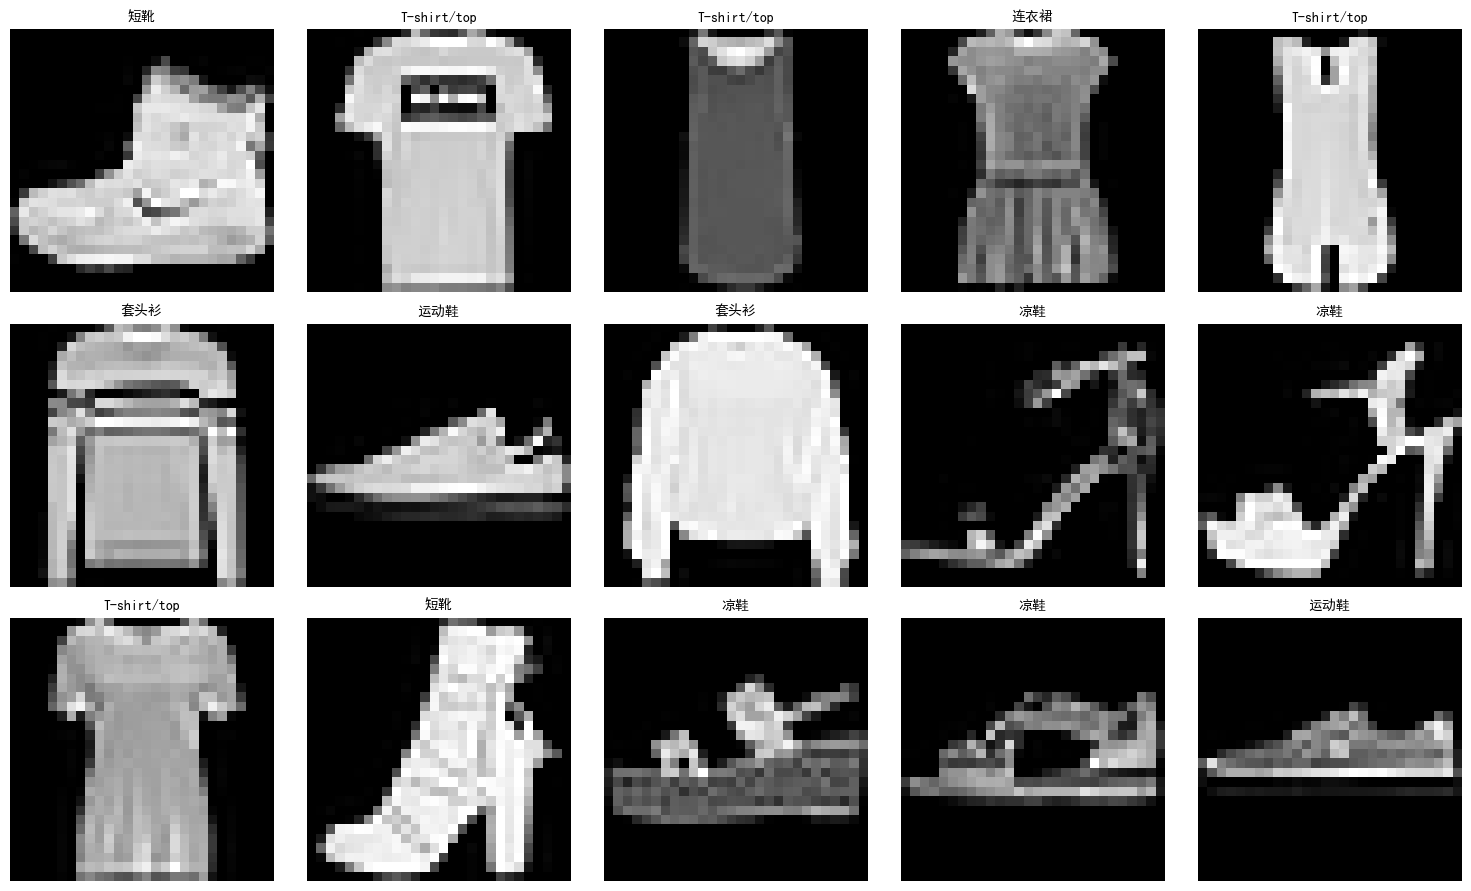

In [5]:
# 导入matplotlib用于绘图
import matplotlib.pyplot as plt
import matplotlib
# 设置中文字体，解决中文显示问题
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建一个3行5列的图表来显示前15个样本
plt.figure(figsize=(15, 9))  # 设置图表大小

# 遍历前15个样本
for i in range(15):
    # 创建子图
    plt.subplot(3, 5, i + 1)
    
    # 显示图像
    plt.imshow(train_images[i], cmap='gray')
    
    # 添加标题（显示类别名称）
    plt.title(class_names[train_labels[i]], fontsize=10)
    
    # 关闭坐标轴
    plt.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()


In [6]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")

训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        # 继承父类nn.Module的初始化
        super().__init__()
        # 输入层 -> 第一隐藏层 (28*28=784 -> 300)
        # nn.Linear创建一个全连接层，将784个输入特征转换为300个输出特征
        self.fc1 = nn.Linear(28*28, 300)
        # 第一隐藏层 -> 第二隐藏层 (300 -> 100)
        # 将300个特征进一步压缩为100个特征
        self.fc2 = nn.Linear(300, 100)
        # 第二隐藏层 -> 输出层 (100 -> 10，对应10个数字类别)
        # 最终输出10个特征，对应Fashion MNIST的10个类别
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x):#forward是前向传播（正向计算），x是输入
        # print("输入形状:", x.shape)
        # 将输入张量展平,view就是reshape
        # -1表示自动计算这个维度的大小，这里将图像从2D转换为1D
        x = x.view(-1, 28*28)
        # print("展平后形状:", x.shape)
        # 第一隐藏层，使用ReLU激活函数
        # ReLU函数将负值置为0，保持正值不变，增加网络的非线性能力
        x = F.relu(self.fc1(x))
        # print("第一隐藏层后形状:", x.shape)
        # 第二隐藏层，使用ReLU激活函数
        # 继续通过ReLU增加非线性变换
        x = F.relu(self.fc2(x))
        # print("第二隐藏层后形状:", x.shape)
        # 输出层，不使用激活函数（交叉熵损失函数会在内部应用softmax）
        # 最后一层不需要激活函数，因为后续的交叉熵损失会包含softmax操作
        x = self.fc3(x)
        # print("输出层形状:", x.shape)
        return x


In [8]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    
    # 选择第一张图像并添加批次维度
    first_image = images[0].unsqueeze(0)
    first_output = model(first_image)
    
    # 打印第一张图像的预测结果
    print("第一张图像的输出形状:", first_output.shape)
    print("第一张图像的预测值:", first_output)
    print("第一张图像的实际标签:", labels[0])
    
    # 获取预测的类别
    predicted_class = torch.argmax(first_output).item()
    print("预测的类别:", predicted_class)
    print("实际的类别:", labels[0].item())


批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
第一张图像的输出形状: torch.Size([1, 10])
第一张图像的预测值: tensor([[ 0.0474, -0.1523, -0.0473,  0.2496, -0.0041,  0.0536, -0.1301,  0.1393,
         -0.0229, -0.1848]])
第一张图像的实际标签: tensor(2)
预测的类别: 3
实际的类别: 2


In [9]:
# 初始化总参数量计数器
total_params = 0
print("模型参数量明细:")

# 遍历模型的所有参数
for name, param in model.named_parameters():
    # 计算当前层的参数数量
    param_count = param.numel()  # numel()返回张量中元素的总数
    # 累加到总参数量
    total_params += param_count
    # 打印当前层的名称和参数量
    print(f"{name}: {param_count:,} 参数")
print(f"\n总参数量: {total_params:,}")


模型参数量明细:
fc1.weight: 235,200 参数
fc1.bias: 300 参数
fc2.weight: 30,000 参数
fc2.bias: 100 参数
fc3.weight: 1,000 参数
fc3.bias: 10 参数

总参数量: 266,610


In [10]:
class EarlyStopping:
    """
    早停类：当验证集准确率在一定轮数内不再提高时，停止训练
    
    参数:
        patience: 容忍验证集准确率不提升的轮数
        delta: 判定准确率是否提升的阈值
        verbose: 是否打印早停信息
    """
    def __init__(self, patience=5, delta=0, verbose=True):
        # patience: 容忍多少个epoch验证集准确率不提升
        self.patience = patience 
        # delta: 判定准确率提升的最小变化阈值,小于此值视为没有提升
        self.delta = delta 
        # counter: 记录连续多少个epoch验证准确率没有提升
        self.counter = 0 
        # best_score: 记录历史最佳验证准确率
        self.best_score = None
        # early_stop: 是否触发早停的标志
        self.early_stop = False
        
    def __call__(self, val_acc):
        # 获取当前epoch的验证准确率
        score = val_acc
        
        # 如果是第一次调用,初始化best_score为当前准确率
        if self.best_score is None:
            self.best_score = score
            return
        
        # 当前准确率未超过历史最佳准确率+阈值delta时
        if score <= self.best_score + self.delta:
            # 累加未提升的epoch计数
            self.counter += 1
            # 当未提升的epoch数达到patience时触发早停
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"早停触发! 最佳验证准确率: {self.best_score:.4f}")
        # 当前准确率超过历史最佳时
        else:
            # 更新历史最佳准确率
            self.best_score = score
            # 重置未提升的epoch计数
            self.counter = 0


In [11]:
import os
class ModelSaver:
    """
    模型保存类：根据配置保存模型权重
    
    参数:
        save_dir: 模型保存目录
        save_best_only: 是否只保存最佳模型
        verbose: 是否打印保存信息
    """
    def __init__(self, save_dir='model_weights', save_best_only=True):
        # 初始化保存路径，默认为'model_weights'
        self.save_dir = save_dir
        # 是否只保存最佳模型的标志，默认为True
        self.save_best_only = save_best_only
        # 记录最佳验证准确率，初始为None
        self.best_score = None
        
        # 如果保存目录不存在，则创建该目录
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
            
    def __call__(self, model, epoch, val_acc):
        """
        保存模型
        
        参数:
            model: 需要保存的模型
            epoch: 当前训练轮数
            val_acc: 当前验证准确率
        """
        # 根据epoch和准确率生成模型文件名
        filename = f'model_epoch_{epoch}_acc_{val_acc:.4f}.pth'
        save_path = os.path.join(self.save_dir, filename)
        
        if self.save_best_only:
            # 如果是首次保存，或当前模型性能优于之前最佳模型
            if self.best_score is None or val_acc > self.best_score:
                # 更新最佳分数
                self.best_score = val_acc
                # 保存当前模型
                torch.save(model.state_dict(), save_path)
                
                # 删除之前保存的其他模型文件
                for old_file in os.listdir(self.save_dir):
                    if old_file != filename and old_file.endswith('.pth'):
                        os.remove(os.path.join(self.save_dir, old_file))
        else:
            # 如果不是只保存最佳模型，则每个epoch都保存
            torch.save(model.state_dict(), save_path)


In [12]:
from torch.utils.tensorboard import SummaryWriter

# TensorboardLogger类用于记录深度学习训练过程中的各种指标
# 包括训练损失、准确率、验证损失、准确率、学习率等
# 这些数据可以通过Tensorboard可视化工具进行查看和分析
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录
    """
    def __init__(self, log_dir='tensorboard_logs'):
        # 导入os模块用于文件和目录操作
        import os
        
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        # 创建SummaryWriter实例，用于写入tensorboard日志
        # log_dir指定日志文件保存的位置
        self.writer = SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘
        
    def log_training(self, epoch, train_loss, train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        # add_scalar方法用于记录标量值
        # 第一个参数是指标名称，第二个参数是具体值，第三个参数是步数/轮数
        self.writer.add_scalar('训练/损失', train_loss, epoch)
        self.writer.add_scalar('训练/准确率', train_acc, epoch)
        
    def log_validation(self, epoch, val_loss, val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        # 记录验证集上的损失和准确率
        self.writer.add_scalar('验证/损失', val_loss, epoch)
        self.writer.add_scalar('验证/准确率', val_acc, epoch)
    
    def log_lr(self, epoch, lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        # 记录当前的学习率
        self.writer.add_scalar('学习率', lr, epoch)
        
    def log_model_graph(self, model, images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """
        # add_graph方法用于可视化模型结构
        # 需要传入模型实例和一个输入样本
        self.writer.add_graph(model, images)
        
    def close(self):
        """
        关闭Tensorboard写入器
        """
        # 关闭writer，确保所有数据都已写入磁盘
        self.writer.close()


In [13]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器

print("损失函数:", criterion)
print("优化器:", optimizer)


损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [14]:
def evaluate_model(model, test_loader, device, criterion=None):
    """评估模型在测试集上的性能
    
    参数:
        model: 待评估的模型
        test_loader: 测试数据加载器
        device: 运行设备(GPU/CPU)
        criterion: 损失函数,默认为None
        
    返回:
        accuracy: 模型在测试集上的准确率
        avg_loss: 如果提供了criterion,则返回平均损失值
    """
    # 将模型设置为评估模式,不进行反向传播
    model.eval()  # 设置为评估模式
    # 初始化正确预测数和总样本数的计数器
    correct = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():  # 不计算梯度
        # 遍历测试数据集中的每一批数据
        for images, labels in test_loader:
            # 将数据转移到指定设备(GPU/CPU)
            images, labels = images.to(device), labels.to(device)
            # 前向传播得到模型输出
            outputs = model(images)
            # 获取每个样本的预测结果(最大概率的类别)
            _, predicted = torch.max(outputs.data, 1)
            # 累加当前批次的样本总数
            total += labels.size(0)
            # 累加当前批次中预测正确的样本数
            correct += (predicted == labels).sum().item()
            
            # 如果提供了损失函数，计算损失
            if criterion is not None:
                # 计算当前批次的损失值
                loss = criterion(outputs, labels)
                # 累加损失值(乘以批次大小以获得加权和)
                total_loss += loss.item() * labels.size(0)
    
    # 计算总体准确率(百分比)
    accuracy = 100 * correct / total
    
    if criterion is not None:
        # 计算平均损失(总损失除以总样本数)
        avg_loss = total_loss / total
        return accuracy, avg_loss
    
    return accuracy


In [15]:
from tqdm.notebook import tqdm  # 使用专门为Jupyter优化的tqdm版本

def train_model1(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs, 
    tensorboard_logger=None,
    model_saver=None,
    early_stopping=None,
    eval_step=500
):
    """
    基于tqdm的训练函数，与training函数类似
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 训练设备
        num_epochs: 训练轮次
        tensorboard_callback: Tensorboard回调函数
        model_saver: 保存检查点回调函数
        early_stopping: 早停回调函数
        eval_step: 每多少步评估一次
    
    返回:
        record_dict: 包含训练和验证记录的字典
    """
    # 初始化记录字典
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    
    # 创建进度条（使用notebook兼容版本）
    pbar = tqdm(total=num_epochs * len(train_loader), desc="Training Progress")
    
    try:
        for epoch_id in range(num_epochs):
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                logits = model(datas)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                
                preds = logits.argmax(axis=-1)
                acc = (preds == labels).float().mean().item() * 100
                loss_value = loss.item()
                
                record_dict["train"].append({
                    "loss": loss_value, 
                    "acc": acc, 
                    "step": global_step
                })
                
                if global_step % eval_step == 0:
                    val_acc, val_loss = evaluate_model(model, val_loader, device, criterion)
                    record_dict["val"].append({
                        "loss": val_loss, 
                        "acc": val_acc, 
                        "step": global_step
                    })
                    model.train()
                    
                    if tensorboard_logger:
                        tensorboard_logger.log_training(global_step, loss_value, acc)
                        tensorboard_logger.log_validation(global_step, val_loss, val_acc)
                    
                    if model_saver:
                        model_saver(model, val_acc, epoch_id)
                    
                    if early_stopping:
                        early_stopping(val_acc)
                        if early_stopping.early_stop:
                            pbar.close()
                            print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                            return model, record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({
                    "epoch": epoch_id, 
                    "loss": f"{loss_value:.4f}", 
                    "acc": f"{acc:.2f}%",
                    "val_acc": f"{val_acc:.2f}%" if global_step % eval_step == 0 else "N/A"
                })
    
    finally:
        pbar.close()
    
    return model, record_dict

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)
tensorboard_logger=TensorboardLogger(log_dir='logs')

model, history = train_model1(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=tensorboard_logger)

使用设备: cuda:0


Training Progress:   0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 88.6800
早停: 已有5轮验证损失没有改善！


In [17]:
history['train'][-100:-1]

[{'loss': 0.24344000220298767, 'acc': 89.0625, 'step': 9401},
 {'loss': 0.1867186725139618, 'acc': 92.1875, 'step': 9402},
 {'loss': 0.20516908168792725, 'acc': 89.0625, 'step': 9403},
 {'loss': 0.32057055830955505, 'acc': 87.5, 'step': 9404},
 {'loss': 0.12382761389017105, 'acc': 95.3125, 'step': 9405},
 {'loss': 0.2066211998462677, 'acc': 89.0625, 'step': 9406},
 {'loss': 0.10679247975349426, 'acc': 95.3125, 'step': 9407},
 {'loss': 0.1799686700105667, 'acc': 89.0625, 'step': 9408},
 {'loss': 0.17189188301563263, 'acc': 90.625, 'step': 9409},
 {'loss': 0.5533793568611145, 'acc': 84.375, 'step': 9410},
 {'loss': 0.22720743715763092, 'acc': 93.75, 'step': 9411},
 {'loss': 0.22609513998031616, 'acc': 92.1875, 'step': 9412},
 {'loss': 0.2020004689693451, 'acc': 92.1875, 'step': 9413},
 {'loss': 0.22282834351062775, 'acc': 92.1875, 'step': 9414},
 {'loss': 0.23234577476978302, 'acc': 90.625, 'step': 9415},
 {'loss': 0.17726363241672516, 'acc': 92.1875, 'step': 9416},
 {'loss': 0.362529546

In [18]:
history['val'][-1000:-1]

[{'loss': 2.301891514968872, 'acc': 10.34, 'step': 0},
 {'loss': 0.48994786825180053, 'acc': 83.0, 'step': 500},
 {'loss': 0.3988254118680954, 'acc': 85.46, 'step': 1000},
 {'loss': 0.3969938898563385, 'acc': 85.14, 'step': 1500},
 {'loss': 0.3817974496603012, 'acc': 86.9, 'step': 2000},
 {'loss': 0.3479382865905762, 'acc': 87.52, 'step': 2500},
 {'loss': 0.3441144098758698, 'acc': 87.56, 'step': 3000},
 {'loss': 0.34282241671085356, 'acc': 87.6, 'step': 3500},
 {'loss': 0.33962204797267914, 'acc': 87.6, 'step': 4000},
 {'loss': 0.3236783195018768, 'acc': 88.32, 'step': 4500},
 {'loss': 0.33264498846530915, 'acc': 87.96, 'step': 5000},
 {'loss': 0.3495815246105194, 'acc': 87.54, 'step': 5500},
 {'loss': 0.3265785307407379, 'acc': 88.04, 'step': 6000},
 {'loss': 0.31930001721978185, 'acc': 88.48, 'step': 6500},
 {'loss': 0.32064254546165466, 'acc': 88.68, 'step': 7000},
 {'loss': 0.3262885673165321, 'acc': 88.52, 'step': 7500},
 {'loss': 0.3215265308022499, 'acc': 88.52, 'step': 8000},


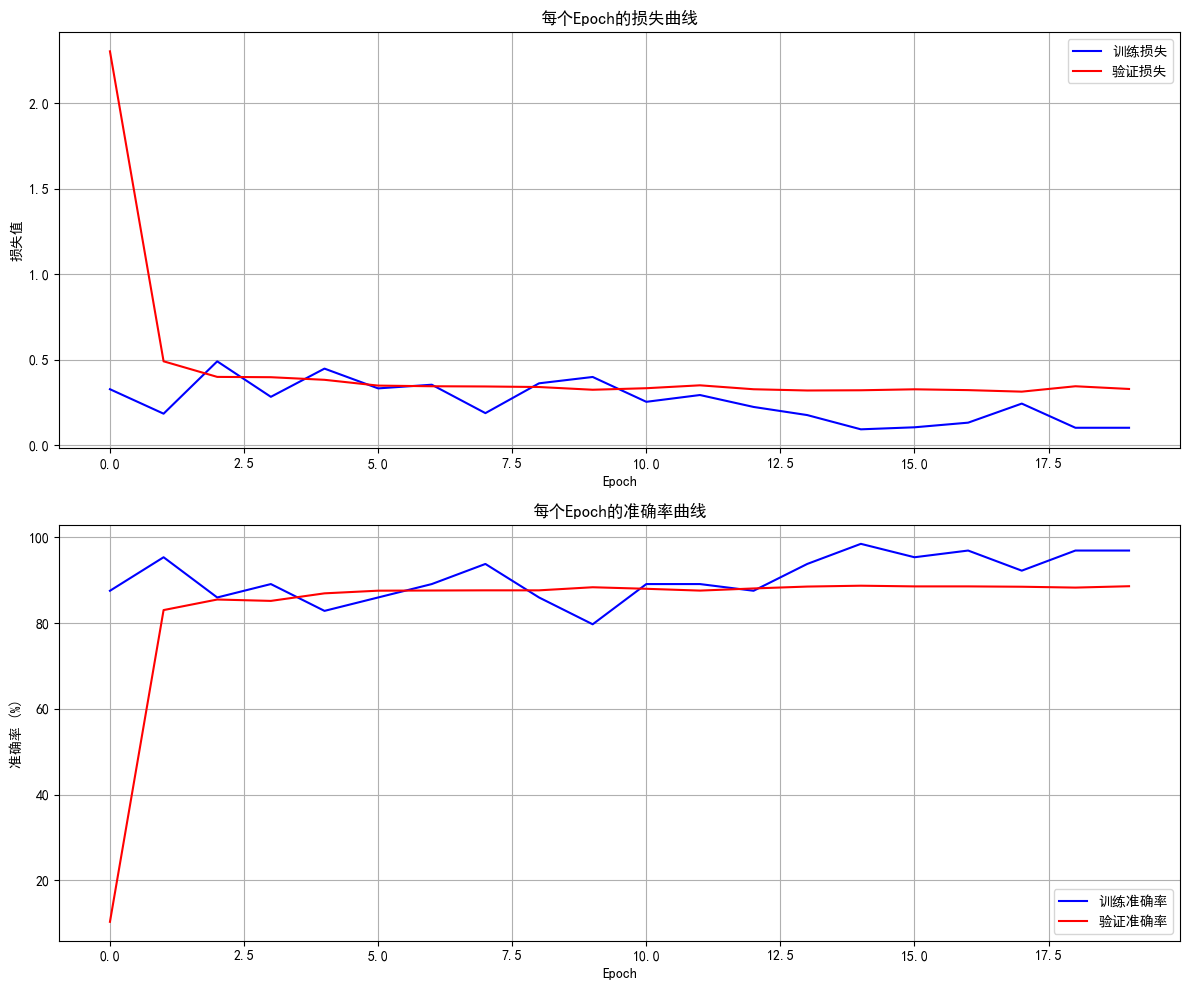

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体，如果环境中有中文字体的话
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
except:
    pass

# 创建一个2行1列的子图布局
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 按照每个epoch统计数据
train_records = history['train']
val_records = history['val']

# 获取每个epoch的最后一个记录
epochs = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# 假设训练数据中，每个epoch的最后一个step是固定的模式
# 根据训练数据中的step来识别epoch边界
if train_records and val_records:
    # 找出每个epoch的最后一步
    max_step = train_records[-1]['step']
    steps_per_epoch = max_step // (len(val_records) - 1) if len(val_records) > 1 else max_step
    
    for i, val_record in enumerate(val_records):
        epochs.append(i)
        val_losses.append(val_record['loss'])
        val_accs.append(val_record['acc'])
        
        # 寻找对应epoch下的训练记录
        if i < len(val_records) - 1:
            matching_train_records = [r for r in train_records if r['step'] <= (i+1)*steps_per_epoch and r['step'] > i*steps_per_epoch]
        else:
            matching_train_records = [r for r in train_records if r['step'] > i*steps_per_epoch]
            
        if matching_train_records:
            # 使用该epoch最后一个训练记录
            train_losses.append(matching_train_records[-1]['loss'])
            train_accs.append(matching_train_records[-1]['acc'])
        elif i > 0 and train_losses:  # 如果没有找到匹配的训练记录，使用上一个epoch的值
            train_losses.append(train_losses[-1])
            train_accs.append(train_accs[-1])
        else:
            train_losses.append(0)
            train_accs.append(0)

# 绘制损失曲线
ax1.plot(epochs, train_losses, 'b-', label='训练损失')
ax1.plot(epochs, val_losses, 'r-', label='验证损失')
ax1.set_title('每个Epoch的损失曲线')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('损失值')
ax1.legend()
ax1.grid(True)

# 绘制准确率曲线
ax2.plot(epochs, train_accs, 'b-', label='训练准确率')
ax2.plot(epochs, val_accs, 'r-', label='验证准确率')
ax2.set_title('每个Epoch的准确率曲线')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('准确率 (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [21]:

# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device)
test_accuracy

88.84